# ============================================================================
# Aureus Sigma Capital - Phase 22c: Unified Backtest Engine & Factor Rebuild
# Notebook: 22c_unified_backtest_engine.ipynb
#
# Objective:
#   To implement the "Methodology Hardening" and "Factor-Stack Rebuild" phases
#   as defined in the strategic assessments (assessment_v1.md, assessment_v2.md).
#   This notebook will create a single, unified, and flexible backtesting engine
#   and use it to build and test a robust QVR composite signal with
#   survivorship-bias-free data.
# ============================================================================
#
# --- STRATEGIC DIRECTIVE & ALIGNMENT ---
#
# This notebook directly implements the strategic roadmap laid out in the formal
# assessments. Key directives include:
#
# 1.  **Discard Old Results:** Performance metrics from notebooks 15, 16, and 17
#     are considered unreliable due to survivorship bias and will not be used
#     as benchmarks.
# 2.  **Establish True Baseline:** The performance of the `Standalone Value`
#     strategy from the `CanonicalBacktester v1.6` (Sharpe ~0.52) is the
#     official baseline to be improved upon.
# 3.  **Unify the Engine:** We will fork the `CanonicalBacktester` to create a
#     more flexible engine with a "factor_combiner" hook, allowing us to test
#     various composite signals within the same robust, point-in-time correct
#     framework.
# 4.  **Isolate Variables:** This notebook will focus exclusively on finding the
#     optimal alpha signal. Risk overlays (volatility targeting, sector caps, etc.)
#     will be implemented in a separate, subsequent phase (Phase 23).
#
# --- PRIMARY RESEARCH QUESTION ---
#
# Can a QVR composite, built and tested within a methodologically pure,
# dynamic-universe framework, achieve a Sharpe Ratio >= 1.0 and a
# Maximum Drawdown <= -35% over the full 2016-2025 period?
#
# --- METHODOLOGY: FACTOR-STACK REBUILD ---
#
# This notebook will execute the following logical steps:
#
# 1.  **Engine Upgrade:** Refactor `CanonicalBacktester v1.6` into a new
#     `UnifiedBacktester` class. This new class will feature a flexible
#     `factor_combiner` that can accept different factor sets and weighting
#     schemes as configuration parameters.
#
# 2.  **Signal Engineering:** Inside the backtesting loop, for each rebalance date:
#     a.  Construct the point-in-time liquid universe.
#     b.  Fetch raw Quality, Value, and Momentum scores for that universe.
#     c.  Engineer the Momentum Reversal signal (`-1 * Momentum`).
#     d.  Re-normalize all three individual signals (Q, V, R) within the
#         period's liquid universe.
#     e.  Combine the re-normalized signals using a specified weighting scheme
#         to create the final composite score.
#
# 3.  **Definitive Bake-Off:** We will test two primary composite configurations
#     against our baseline:
#     -   **Strategy A (Baseline):** `Standalone Value`
#     -   **Strategy B:** `Equal-Weighted QVR`
#     -   **Strategy C:** `Value-Weighted QVR (60/20/20)`
#
# --- SUCCESS CRITERIA (from assessment_v2) ---
#
# The primary goal of this phase is to produce a composite signal that meets the
# following hurdles, which will then make it a candidate for risk overlays:
#
#   -   **Sharpe Ratio (2016-2025):** >= 1.0
#   -   **Maximum Drawdown:** <= -35%
#

In [1]:
# ============================================================================
# PHASE 1: SETUP & CONFIGURATION
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
import yaml
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- Module Import Logic ---
try:
    project_root = Path.cwd().parent.parent.parent
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    from production.universe.constructors import get_liquid_universe_dataframe
    print("✅ Successfully imported production modules.")
except Exception as e:
    print(f"❌ ERROR during module import: {e}")


# --- Standardized Institutional Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': PALETTE['text'],
    'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': PALETTE['text'],
    'axes.titlepad': 15, 'axes.titlesize': 16, 'axes.titleweight': 'bold',
    'axes.titlecolor': PALETTE['text'], 'grid.color': PALETTE['grid'],
    'legend.frameon': False, 'xtick.color': PALETTE['text'], 'ytick.color': PALETTE['text'],
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})
print("✅ Visualization settings configured.")


# --- Core Backtest Configurations for the Bake-Off ---
# We define a dictionary for each strategy to be tested.
# This allows our new UnifiedBacktester to be highly flexible.

BASE_CONFIG = {
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "strategy_version_db": "qvm_v2.0_enhanced",
    "transaction_cost_bps": 30,
    "construction_method": "percentile",
    "selection_percentile": 0.8 # Top 20%
}

# Strategy A: The Baseline
CONFIG_A = {
    **BASE_CONFIG,
    "strategy_name": "A_Standalone_Value",
    "factors_to_combine": {
        'Value_Composite': 1.0
    }
}

# Strategy B: Equal-Weighted QVR
CONFIG_B = {
    **BASE_CONFIG,
    "strategy_name": "B_Equal_Weighted_QVR",
    "factors_to_combine": {
        'Value_Composite': 1/3,
        'Quality_Composite': 1/3,
        'Momentum_Reversal': 1/3
    }
}

# Strategy C: Value-Weighted QVR
CONFIG_C = {
    **BASE_CONFIG,
    "strategy_name": "C_Value_Weighted_QVR",
    "factors_to_combine": {
        'Value_Composite': 0.6,
        'Quality_Composite': 0.2,
        'Momentum_Reversal': 0.2
    }
}

print("✅ Backtest configurations defined for all three strategies in the bake-off.")
print(f"   - Baseline: {CONFIG_A['strategy_name']}")
print(f"   - Test 1:   {CONFIG_B['strategy_name']}")
print(f"   - Test 2:   {CONFIG_C['strategy_name']}")

✅ Successfully imported production modules.
✅ Visualization settings configured.
✅ Backtest configurations defined for all three strategies in the bake-off.
   - Baseline: A_Standalone_Value
   - Test 1:   B_Equal_Weighted_QVR
   - Test 2:   C_Value_Weighted_QVR


In [2]:
# ============================================================================
# PHASE 1: SETUP & CONFIGURATION (v1.1 - Expanded Bake-Off)
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
import yaml
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- Module Import Logic ---
try:
    project_root = Path.cwd().parent.parent.parent
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    from production.universe.constructors import get_liquid_universe_dataframe
    print("✅ Successfully imported production modules.")
except Exception as e:
    print(f"❌ ERROR during module import: {e}")


# --- Standardized Institutional Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': PALETTE['text'],
    'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': PALETTE['text'],
    'axes.titlepad': 15, 'axes.titlesize': 16, 'axes.titleweight': 'bold',
    'axes.titlecolor': PALETTE['text'], 'grid.color': PALETTE['grid'],
    'legend.frameon': False, 'xtick.color': PALETTE['text'], 'ytick.color': PALETTE['text'],
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})
print("✅ Visualization settings configured.")


# --- Core Backtest Configurations for the EXPANDED Bake-Off ---
# Based on your feedback, we will explicitly test Momentum vs. Reversal.

BASE_CONFIG = {
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "strategy_version_db": "qvm_v2.0_enhanced",
    "transaction_cost_bps": 30,
    "construction_method": "percentile",
    "selection_percentile": 0.8 # Top 20%
}

# Strategy A: The Baseline
CONFIG_A = {
    **BASE_CONFIG,
    "strategy_name": "A_Standalone_Value",
    "factors_to_combine": {
        'Value_Composite': 1.0
    }
}

# Strategy B: Traditional QVM (with positive Momentum)
CONFIG_B = {
    **BASE_CONFIG,
    "strategy_name": "B_Equal_Weighted_QVM",
    "factors_to_combine": {
        'Value_Composite': 1/3,
        'Quality_Composite': 1/3,
        'Momentum_Composite': 1/3 # Using standard Momentum
    }
}

# Strategy C: QVR (with Momentum Reversal)
CONFIG_C = {
    **BASE_CONFIG,
    "strategy_name": "C_Equal_Weighted_QVR",
    "factors_to_combine": {
        'Value_Composite': 1/3,
        'Quality_Composite': 1/3,
        'Momentum_Reversal': 1/3 # Using Reversal
    }
}

# Strategy D: Value-Weighted QVM (with positive Momentum)
CONFIG_D = {
    **BASE_CONFIG,
    "strategy_name": "D_Value_Weighted_QVM",
    "factors_to_combine": {
        'Value_Composite': 0.6,
        'Quality_Composite': 0.2,
        'Momentum_Composite': 0.2 # Using standard Momentum
    }
}

# Strategy E: Value-Weighted QVR (with Momentum Reversal)
CONFIG_E = {
    **BASE_CONFIG,
    "strategy_name": "E_Value_Weighted_QVR",
    "factors_to_combine": {
        'Value_Composite': 0.6,
        'Quality_Composite': 0.2,
        'Momentum_Reversal': 0.2 # Using Reversal
    }
}

# A list of all configurations to run
ALL_CONFIGS = [CONFIG_A, CONFIG_B, CONFIG_C, CONFIG_D, CONFIG_E]

print("✅ Expanded backtest configurations defined for all five strategies.")
for config in ALL_CONFIGS:
    print(f"   - Registered: {config['strategy_name']}")

✅ Successfully imported production modules.
✅ Visualization settings configured.
✅ Expanded backtest configurations defined for all five strategies.
   - Registered: A_Standalone_Value
   - Registered: B_Equal_Weighted_QVM
   - Registered: C_Equal_Weighted_QVR
   - Registered: D_Value_Weighted_QVM
   - Registered: E_Value_Weighted_QVR


In [3]:
# ============================================================================
# PHASE 2: DATA PREPARATION
# ============================================================================

# --- Database Connection ---
def create_db_connection():
    """
    Establishes a SQLAlchemy database engine connection using the central config file.
    """
    try:
        config_path = project_root / 'config' / 'database.yml'
        with open(config_path, 'r') as f:
            db_config = yaml.safe_load(f)['production']
        
        connection_string = (
            f"mysql+pymysql://{db_config['username']}:{db_config['password']}"
            f"@{db_config['host']}/{db_config['schema_name']}"
        )
        engine = create_engine(connection_string, pool_pre_ping=True)
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
        print(f"✅ Database connection established successfully to schema '{db_config['schema_name']}'.")
        return engine
    except Exception as e:
        print(f"❌ FAILED to connect to the database: {e}")
        return None

# Create the engine for this session
engine = create_db_connection()

# --- Load Raw Data for the Full Backtest Period ---
if engine:
    print("\n📂 Loading all raw data for the full backtest period...")

    # Use a broad date range to ensure all configs are covered
    db_params = {
        'start_date': "2016-01-01", 
        'end_date': BASE_CONFIG['backtest_end_date'],
        'strategy_version': BASE_CONFIG['strategy_version_db']
    }

    # 1. Factor Scores (Load all three base factors)
    factor_query = text("""
        SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite
        FROM factor_scores_qvm
        WHERE date BETWEEN :start_date AND :end_date 
          AND strategy_version = :strategy_version
    """)
    factor_data_raw = pd.read_sql(factor_query, engine, params=db_params, parse_dates=['date'])
    print(f"   - ✅ Loaded {len(factor_data_raw):,} raw factor observations.")

    # 2. Price Data
    price_query = text("""
        SELECT date, ticker, close 
        FROM equity_history
        WHERE date BETWEEN :start_date AND :end_date
    """)
    price_data_raw = pd.read_sql(price_query, engine, params=db_params, parse_dates=['date'])
    print(f"   - ✅ Loaded {len(price_data_raw):,} raw price observations.")

    # 3. Benchmark Data
    benchmark_query = text("""
        SELECT date, close
        FROM etf_history
        WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date
    """)
    benchmark_data_raw = pd.read_sql(benchmark_query, engine, params=db_params, parse_dates=['date'])
    print(f"   - ✅ Loaded {len(benchmark_data_raw):,} benchmark observations.")

    # --- Prepare Data Structures for Backtesting ---
    print("\n🛠️  Preparing data structures for the backtesting engine...")

    # 1. Calculate daily returns and create the returns matrix
    price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
    print(f"   - ✅ Daily returns matrix constructed. Shape: {daily_returns_matrix.shape}")

    # 2. Calculate benchmark returns
    benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN-Index')
    print(f"   - ✅ Benchmark returns calculated. Days: {len(benchmark_returns)}")

    print("\n✅ All data prepared. Ready for the UnifiedBacktester.")
else:
    print("\n❌ Halting execution due to database connection failure.")

✅ Database connection established successfully to schema 'alphabeta'.

📂 Loading all raw data for the full backtest period...
   - ✅ Loaded 1,567,488 raw factor observations.
   - ✅ Loaded 1,610,552 raw price observations.
   - ✅ Loaded 2,388 benchmark observations.

🛠️  Preparing data structures for the backtesting engine...
   - ✅ Daily returns matrix constructed. Shape: (2385, 728)
   - ✅ Benchmark returns calculated. Days: 2388

✅ All data prepared. Ready for the UnifiedBacktester.


In [4]:
# ============================================================================
# PHASE 3 & 4: THE UNIFIED BACKTESTER CLASS (v1.0)
#
# This engine is designed to be flexible and robust, capable of handling
# single-factor and multi-factor composite strategies. It directly implements
# the "factor_combiner" hook requested in the strategic assessments.
# ============================================================================

from typing import Dict, List, Optional

class UnifiedBacktester:
    """
    A flexible backtesting engine that supports single-factor and weighted
    multi-factor composite strategies, built upon the validated logic of v1.6.
    """
    def __init__(self,
                 config: Dict,
                 factor_data: pd.DataFrame,
                 returns_matrix: pd.DataFrame,
                 benchmark_returns: pd.Series,
                 db_engine):
        
        self.config = config
        self.engine = db_engine
        
        # Enforce strict data encapsulation
        start = self.config['backtest_start_date']
        end = self.config['backtest_end_date']
        
        self.factor_data_raw = factor_data[factor_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        
        print(f"✅ UnifiedBacktester v1.0 initialized for strategy: '{self.config['strategy_name']}'")

    def run(self) -> pd.Series:
        """Executes the full, end-to-end backtest."""
        print(f"\n--- Executing Backtest for: {self.config['strategy_name']} ---")
        daily_holdings = self._run_backtesting_loop()
        net_returns = self._calculate_net_returns(daily_holdings)
        self._generate_tearsheet(net_returns)
        print(f"\n✅ Backtest for {self.config['strategy_name']} complete.")
        return net_returns

    def _generate_rebalance_dates(self) -> List[pd.Timestamp]:
        all_trading_dates = self.daily_returns_matrix.index
        freq_ends = pd.date_range(start=all_trading_dates.min(), end=all_trading_dates.max(), freq=self.config['rebalance_frequency'])
        return [all_trading_dates[all_trading_dates.searchsorted(q_end, side='right') - 1] for q_end in freq_ends]

    def _run_backtesting_loop(self) -> pd.DataFrame:
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        
        for i in range(len(rebalance_dates)):
            rebal_date = rebalance_dates[i]
            print(f"   - Processing {rebal_date.date()}... ", end="")
            
            universe_df = get_liquid_universe_dataframe(analysis_date=rebal_date, engine=self.engine, config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6})
            if universe_df.empty: print("⚠️ Universe empty. Skipping."); continue
            
            mask = self.factor_data_raw['date'] == rebal_date
            factors_on_date = self.factor_data_raw.loc[mask]
            factors_on_date = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'].tolist())].copy()
            
            if len(factors_on_date) < 10: print(f"⚠️ Insufficient stocks ({len(factors_on_date)}). Skipping."); continue
            
            target_portfolio = self._calculate_target_portfolio(factors_on_date)
            if target_portfolio.empty: print("⚠️ Portfolio empty. Skipping."); continue
            
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
            print(f"✅ Formed portfolio with {len(target_portfolio)} stocks.")
            
        return daily_holdings

    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        """
        The flexible "factor combiner" hook.
        Engineers, re-normalizes, and combines factors based on the config.
        """
        factors_to_combine = self.config['factors_to_combine']
        
        # --- 1. Engineer any necessary factors ---
        if 'Momentum_Reversal' in factors_to_combine:
            factors_df['Momentum_Reversal'] = -1 * factors_df['Momentum_Composite']
            
        # --- 2. Re-normalize all required base factors ---
        normalized_scores = []
        for factor_name, weight in factors_to_combine.items():
            if weight == 0: continue
            
            factor_scores = factors_df[factor_name]
            mean, std = factor_scores.mean(), factor_scores.std()
            
            if std > 0:
                normalized_score = (factor_scores - mean) / std
            else:
                normalized_score = 0.0
            
            normalized_scores.append(normalized_score * weight)
        
        # --- 3. Combine into the final signal ---
        if not normalized_scores:
            return pd.Series(dtype='float64')
            
        factors_df['final_signal'] = pd.concat(normalized_scores, axis=1).sum(axis=1)
        
        # --- 4. Construct portfolio using the percentile method ---
        percentile_cutoff = self.config.get('selection_percentile', 0.8)
        score_cutoff = factors_df['final_signal'].quantile(percentile_cutoff)
        selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
            
        if selected_stocks.empty:
            return pd.Series(dtype='float64')
            
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1)
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        return (gross_returns - costs).rename(self.config['strategy_name'])

    def _calculate_performance_metrics(self, returns: pd.Series) -> Dict:
        # This function remains the same as the robust version in v1.6
        benchmark = self.benchmark_returns; first_trade_date = returns.loc[returns.ne(0)].index.min(); common_index = returns.loc[first_trade_date:].index.intersection(benchmark.index); returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]; n_years = len(returns) / 252; annual_return = ((1 + returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0; annual_vol = returns.std() * np.sqrt(252); sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0; cumulative = (1 + returns).cumprod(); drawdown = (cumulative / cumulative.cummax() - 1); max_drawdown = drawdown.min(); calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0; excess_returns = returns - benchmark; information_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252)) if excess_returns.std() > 0 else 0; beta = np.cov(returns.fillna(0), benchmark.fillna(0))[0, 1] / np.var(benchmark.fillna(0)); alpha = (returns.mean() - beta * benchmark.mean()) * 252; return {'Annual Return (%)': annual_return*100, 'Annual Volatility (%)': annual_vol*100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown*100, 'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Alpha (%)': alpha*100, 'Information Ratio': information_ratio}

    def _generate_tearsheet(self, strategy_returns: pd.Series):
        # This function also remains the same
        portfolio_metrics = self._calculate_performance_metrics(strategy_returns); benchmark_metrics = self._calculate_performance_metrics(self.benchmark_returns); first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min(); strategy_cum = (1 + strategy_returns.loc[first_trade_date:]).cumprod(); benchmark_cum = (1 + self.benchmark_returns.loc[first_trade_date:]).cumprod(); fig = plt.figure(figsize=(18, 22)); gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.7, wspace=0.2); title = f"Institutional Tearsheet: {self.config['strategy_name']} ({first_trade_date.year}-{strategy_returns.index.max().year})"; fig.suptitle(title, fontsize=20, fontweight='bold', color=PALETTE['text']); ax1 = fig.add_subplot(gs[0, :]); ax1.plot(strategy_cum.index, strategy_cum, label=self.config['strategy_name'], color=PALETTE['primary'], linewidth=2.5); ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=PALETTE['secondary'], linestyle='--', linewidth=2); ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.legend(loc='upper left'); ax2 = fig.add_subplot(gs[1, :]); strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100; ax2.plot(strategy_dd.index, strategy_dd, color=PALETTE['negative'], linewidth=2); ax2.fill_between(strategy_dd.index, strategy_dd, 0, color=PALETTE['negative'], alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); plot_row = 2;
        ax3 = fig.add_subplot(gs[plot_row, 0]); strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = self.benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=[PALETTE['primary'], PALETTE['secondary']]); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax4 = fig.add_subplot(gs[plot_row, 1]); rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252)); ax4.plot(rolling_sharpe.index, rolling_sharpe, color=PALETTE['highlight_2']); ax4.axhline(1.0, color=PALETTE['positive'], linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax5 = fig.add_subplot(gs[plot_row+1:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
        for key in portfolio_metrics.keys(): summary_data.append([key, f"{portfolio_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
        table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5); plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

print("✅ UnifiedBacktester class (v1.0) defined successfully.")
print("   This engine is now ready to run the full five-strategy bake-off.")

✅ UnifiedBacktester class (v1.0) defined successfully.
   This engine is now ready to run the full five-strategy bake-off.


🚀 LAUNCHING BACKTEST FOR: A_Standalone_Value
✅ UnifiedBacktester v1.0 initialized for strategy: 'A_Standalone_Value'

--- Executing Backtest for: A_Standalone_Value ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 192.1B VND
  Market cap range: 199.2B - 156193.8B VND
  Adding sector information...
✅ Formed portfolio with 12 stocks.
   - P

/var/folders/rb/_5jyx5gx6vn69mhckz6xq6040000gn/T/ipykernel_26296/1239709102.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5); plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()


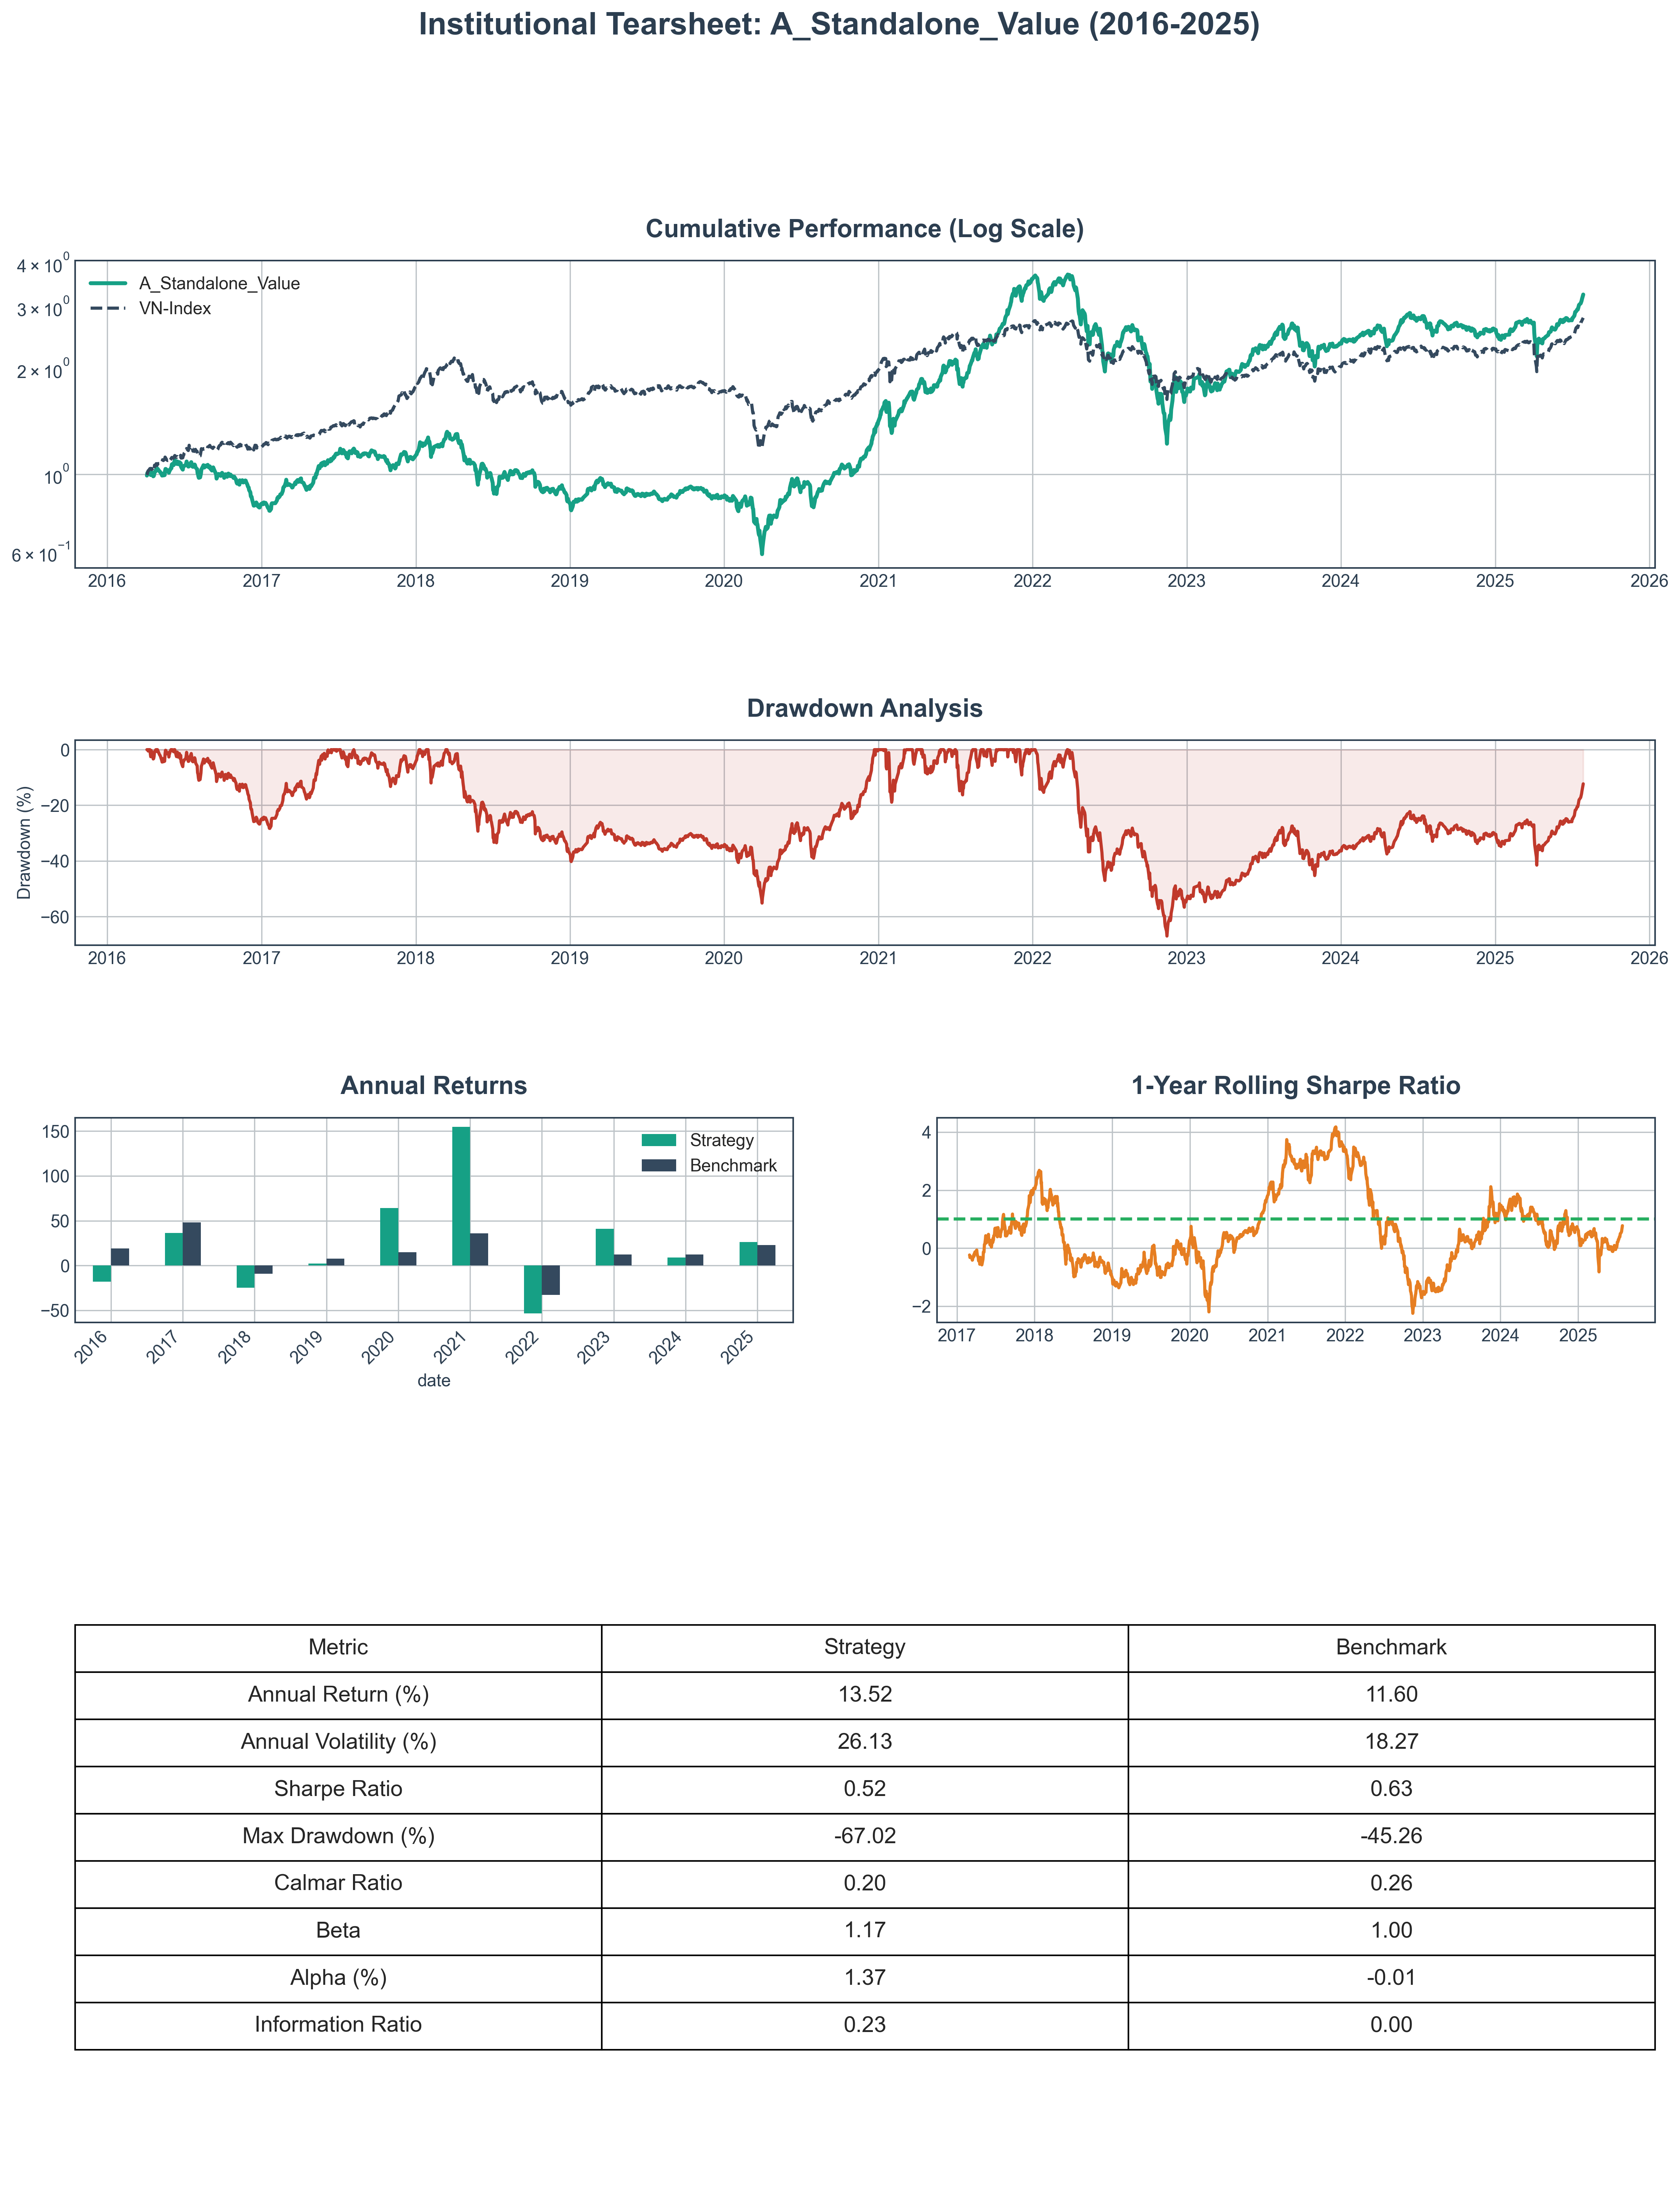


✅ Backtest for A_Standalone_Value complete.

✅ COMPLETED BACKTEST FOR: A_Standalone_Value
🚀 LAUNCHING BACKTEST FOR: B_Equal_Weighted_QVM
✅ UnifiedBacktester v1.0 initialized for strategy: 'B_Equal_Weighted_QVM'

--- Executing Backtest for: B_Equal_Weighted_QVM ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 192.1B VND
  Market cap range

/var/folders/rb/_5jyx5gx6vn69mhckz6xq6040000gn/T/ipykernel_26296/1239709102.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5); plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()


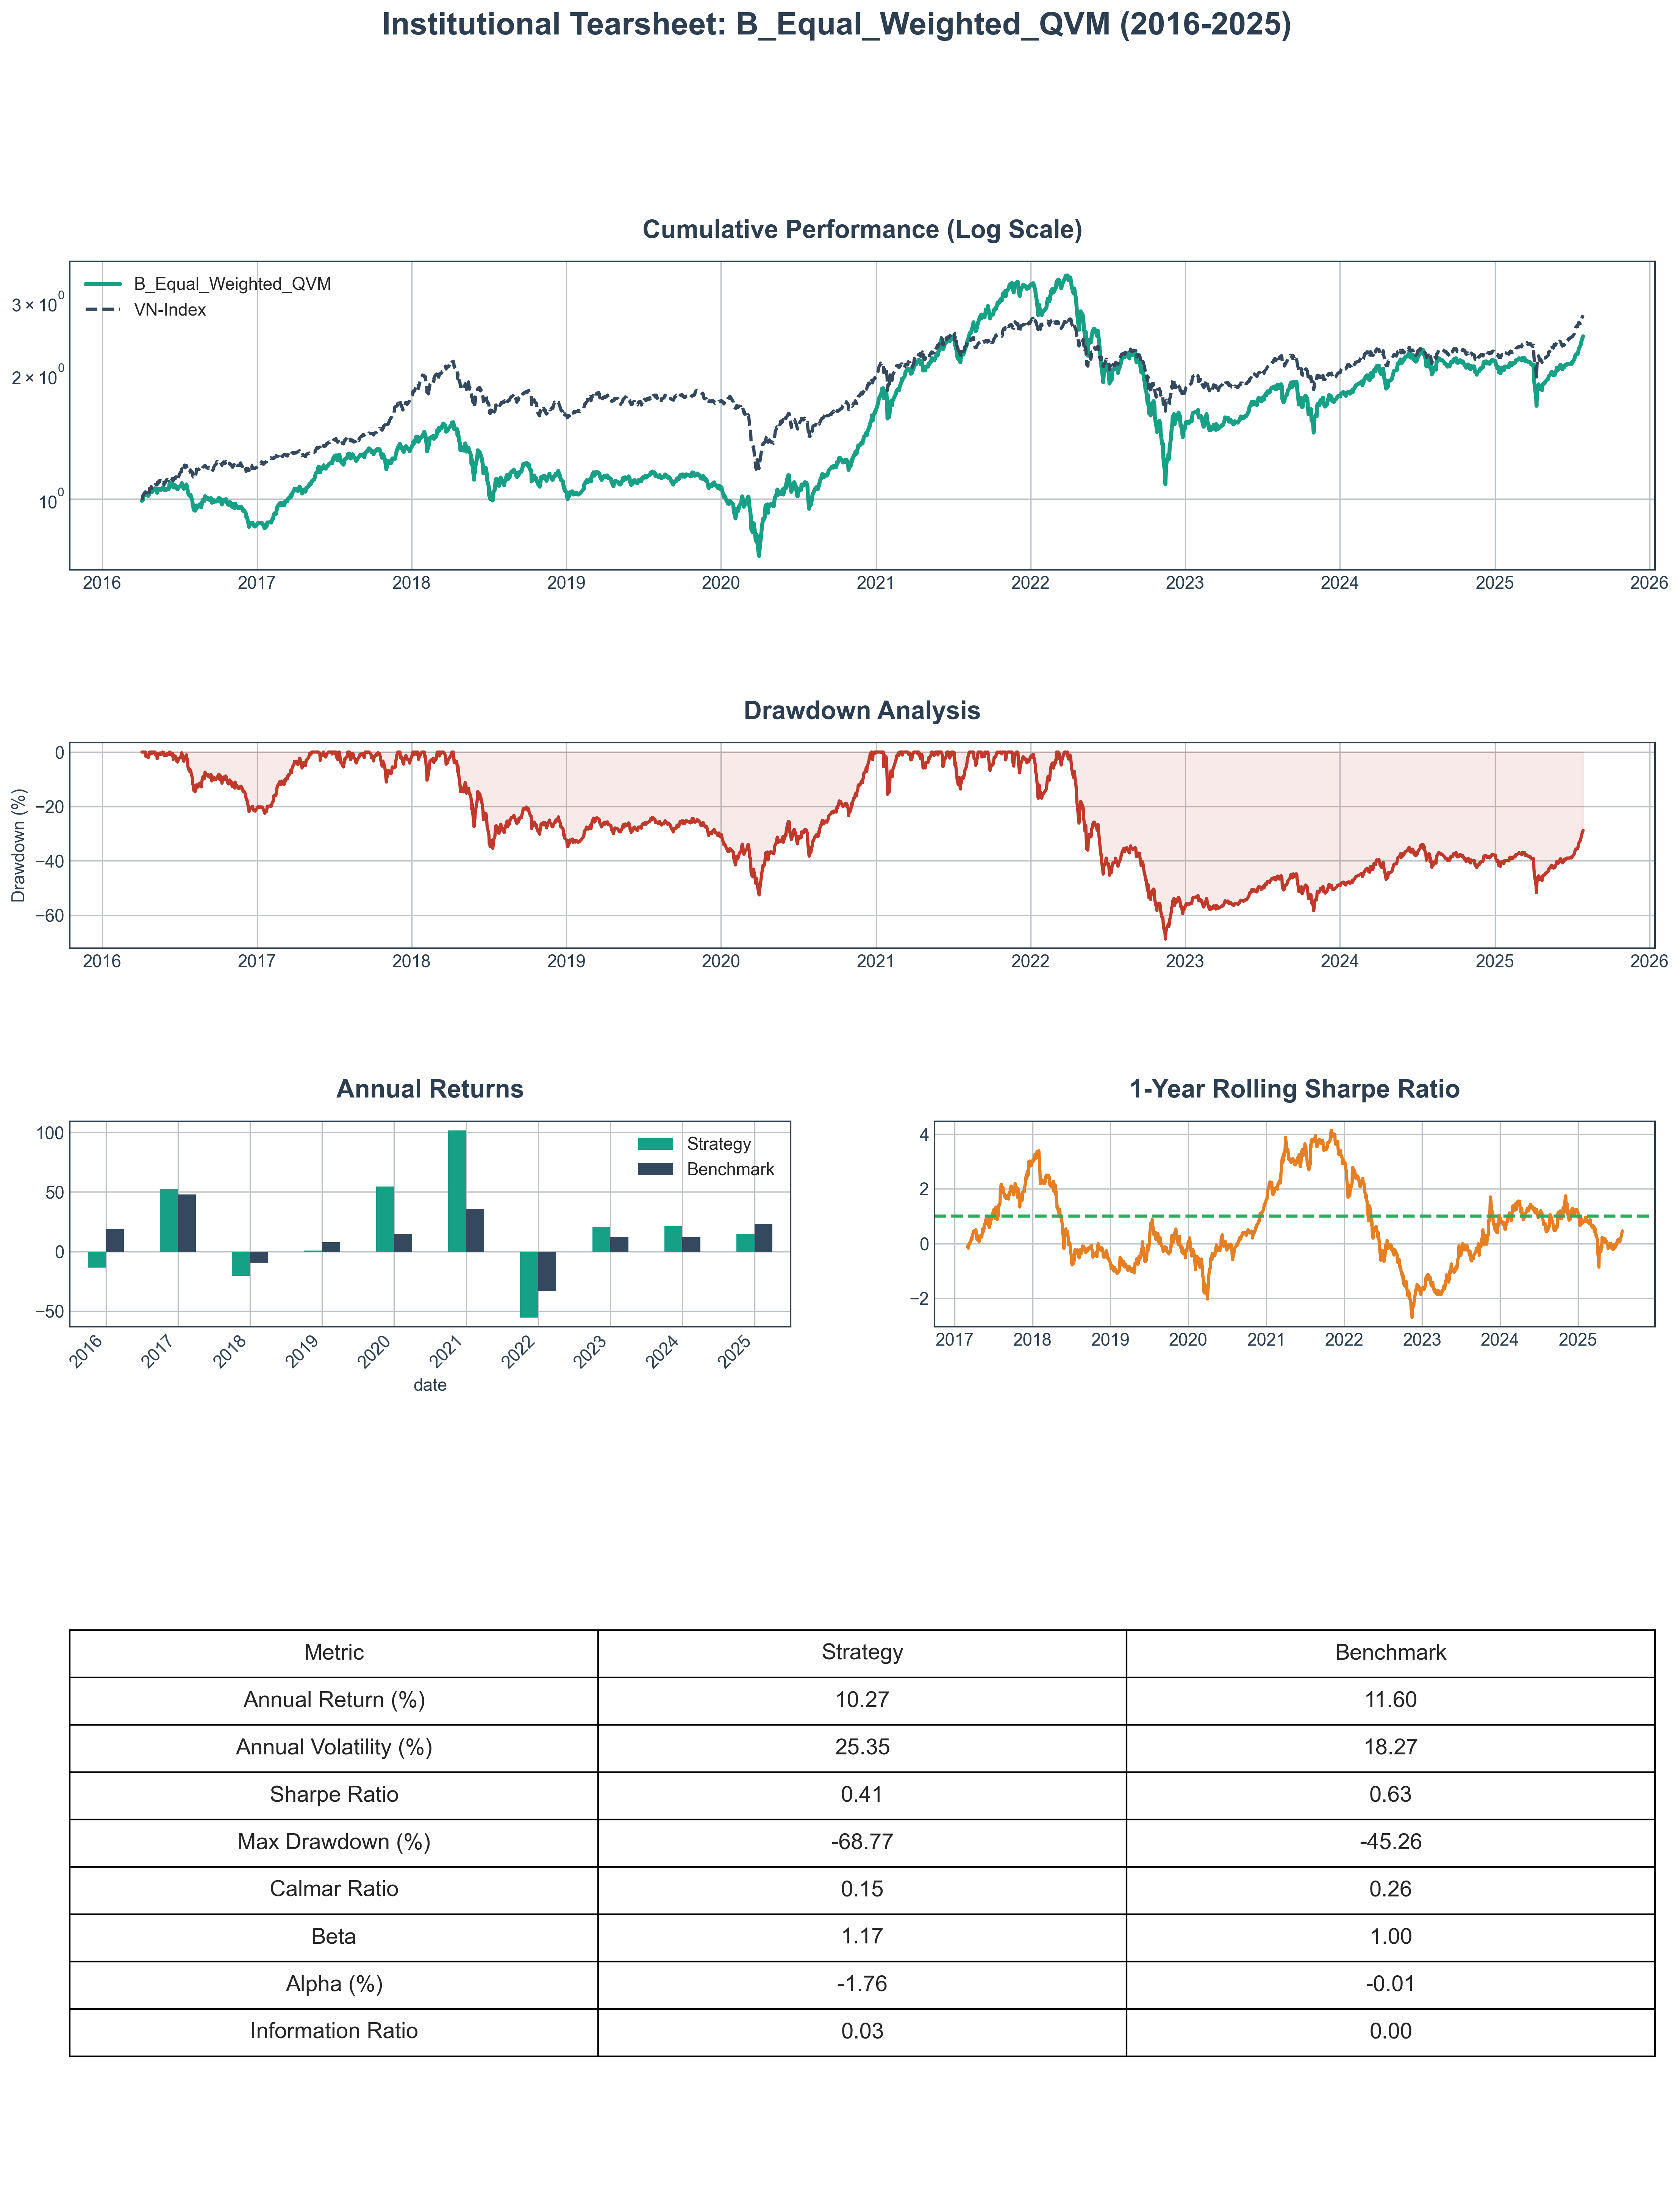


✅ Backtest for B_Equal_Weighted_QVM complete.

✅ COMPLETED BACKTEST FOR: B_Equal_Weighted_QVM
🚀 LAUNCHING BACKTEST FOR: C_Equal_Weighted_QVR
✅ UnifiedBacktester v1.0 initialized for strategy: 'C_Equal_Weighted_QVR'

--- Executing Backtest for: C_Equal_Weighted_QVR ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 192.1B VND
  Market cap r

/var/folders/rb/_5jyx5gx6vn69mhckz6xq6040000gn/T/ipykernel_26296/1239709102.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5); plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()


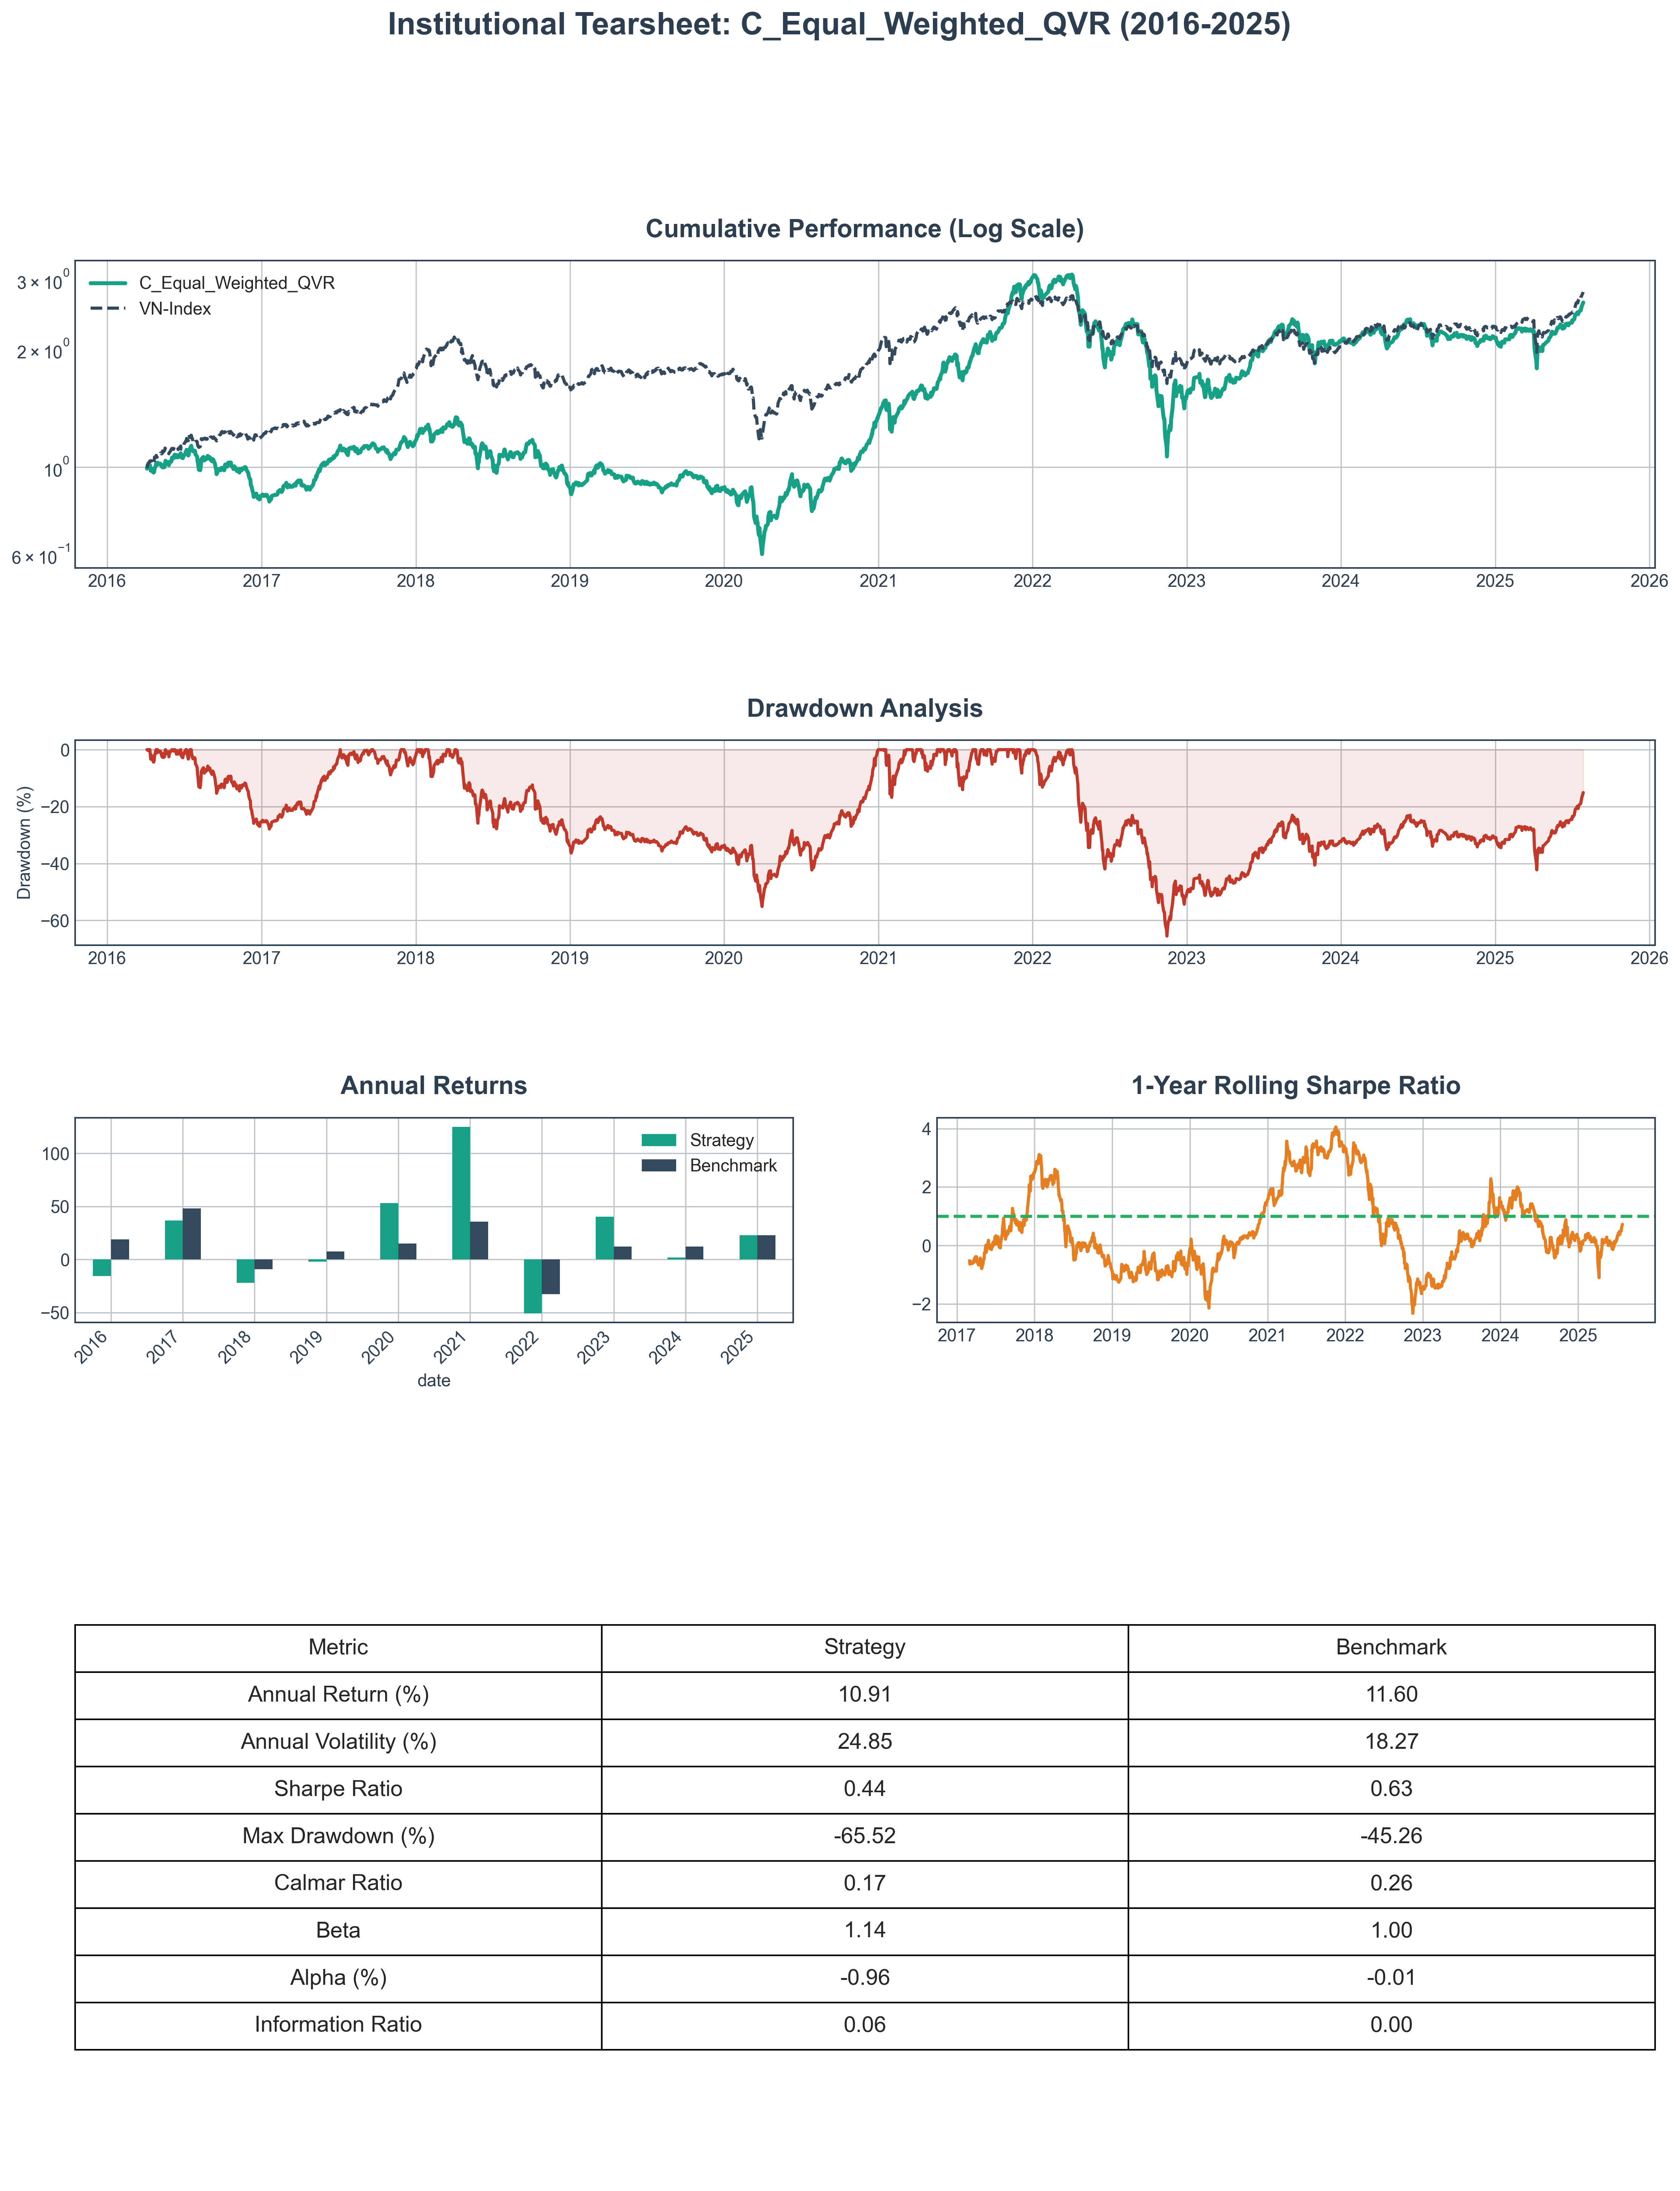


✅ Backtest for C_Equal_Weighted_QVR complete.

✅ COMPLETED BACKTEST FOR: C_Equal_Weighted_QVR
🚀 LAUNCHING BACKTEST FOR: D_Value_Weighted_QVM
✅ UnifiedBacktester v1.0 initialized for strategy: 'D_Value_Weighted_QVM'

--- Executing Backtest for: D_Value_Weighted_QVM ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 192.1B VND
  Market cap r

/var/folders/rb/_5jyx5gx6vn69mhckz6xq6040000gn/T/ipykernel_26296/1239709102.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5); plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()


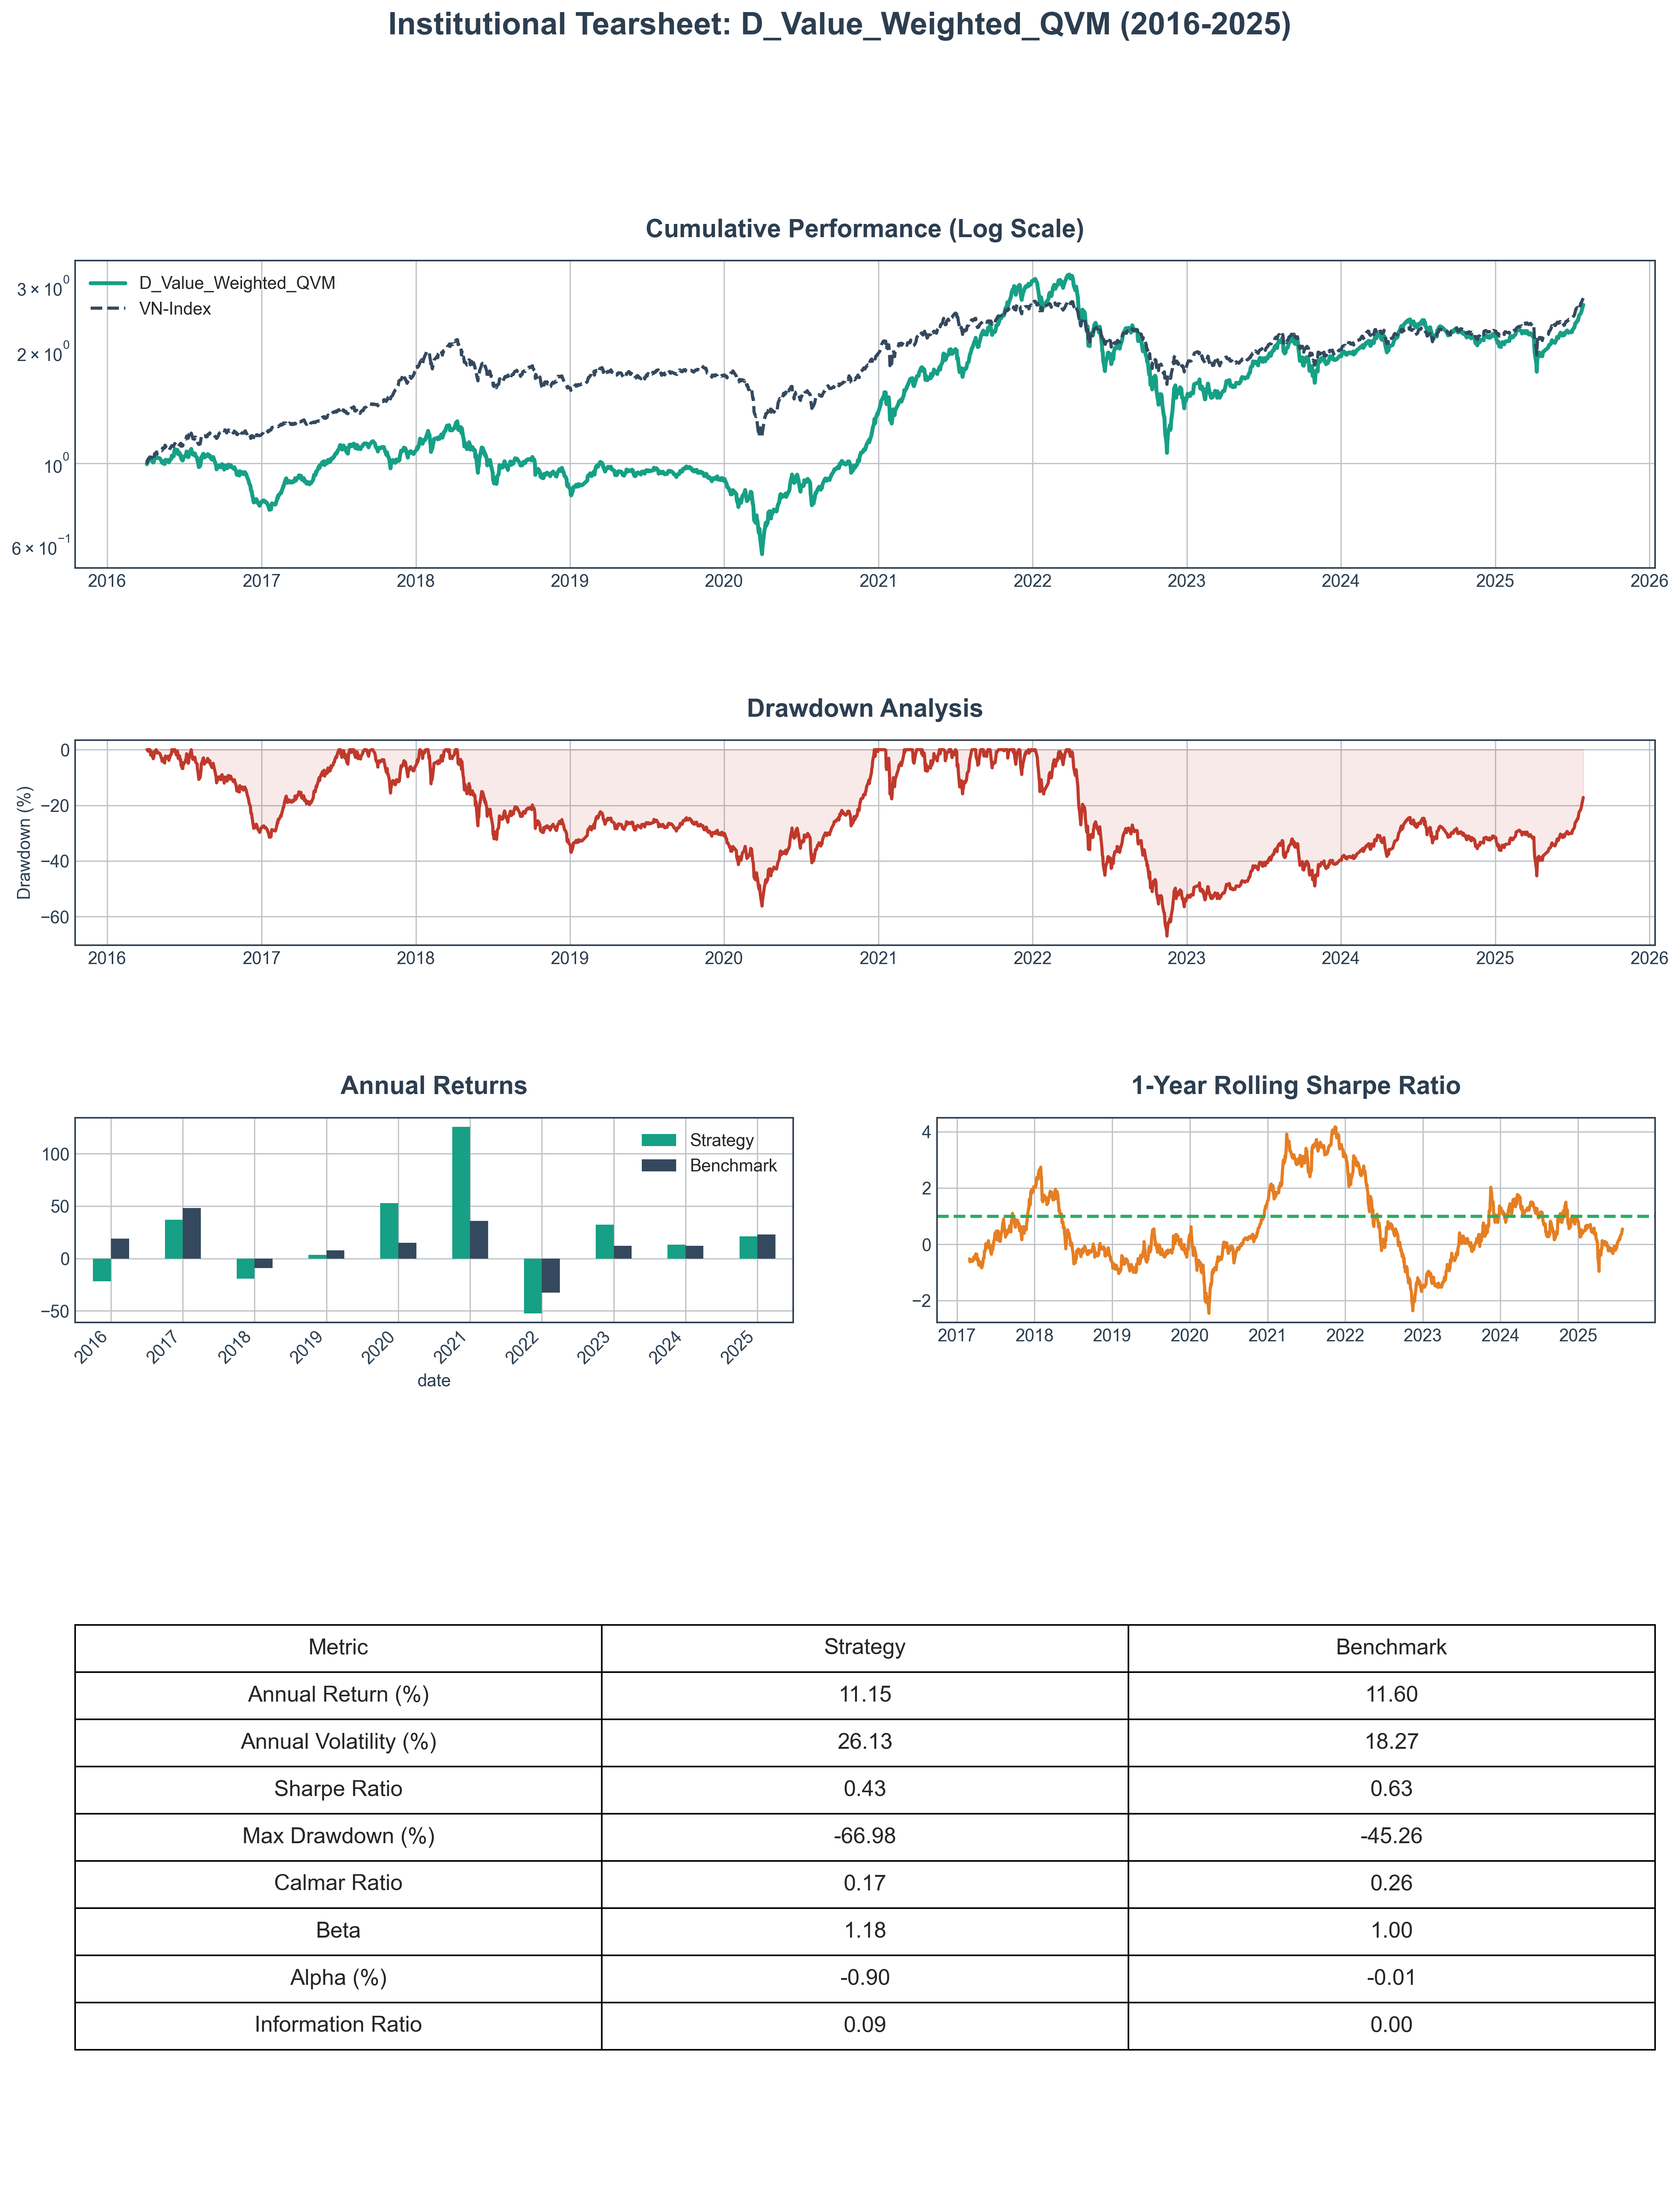


✅ Backtest for D_Value_Weighted_QVM complete.

✅ COMPLETED BACKTEST FOR: D_Value_Weighted_QVM
🚀 LAUNCHING BACKTEST FOR: E_Value_Weighted_QVR
✅ UnifiedBacktester v1.0 initialized for strategy: 'E_Value_Weighted_QVR'

--- Executing Backtest for: E_Value_Weighted_QVR ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 192.1B VND
  Market cap r

/var/folders/rb/_5jyx5gx6vn69mhckz6xq6040000gn/T/ipykernel_26296/1239709102.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5); plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()


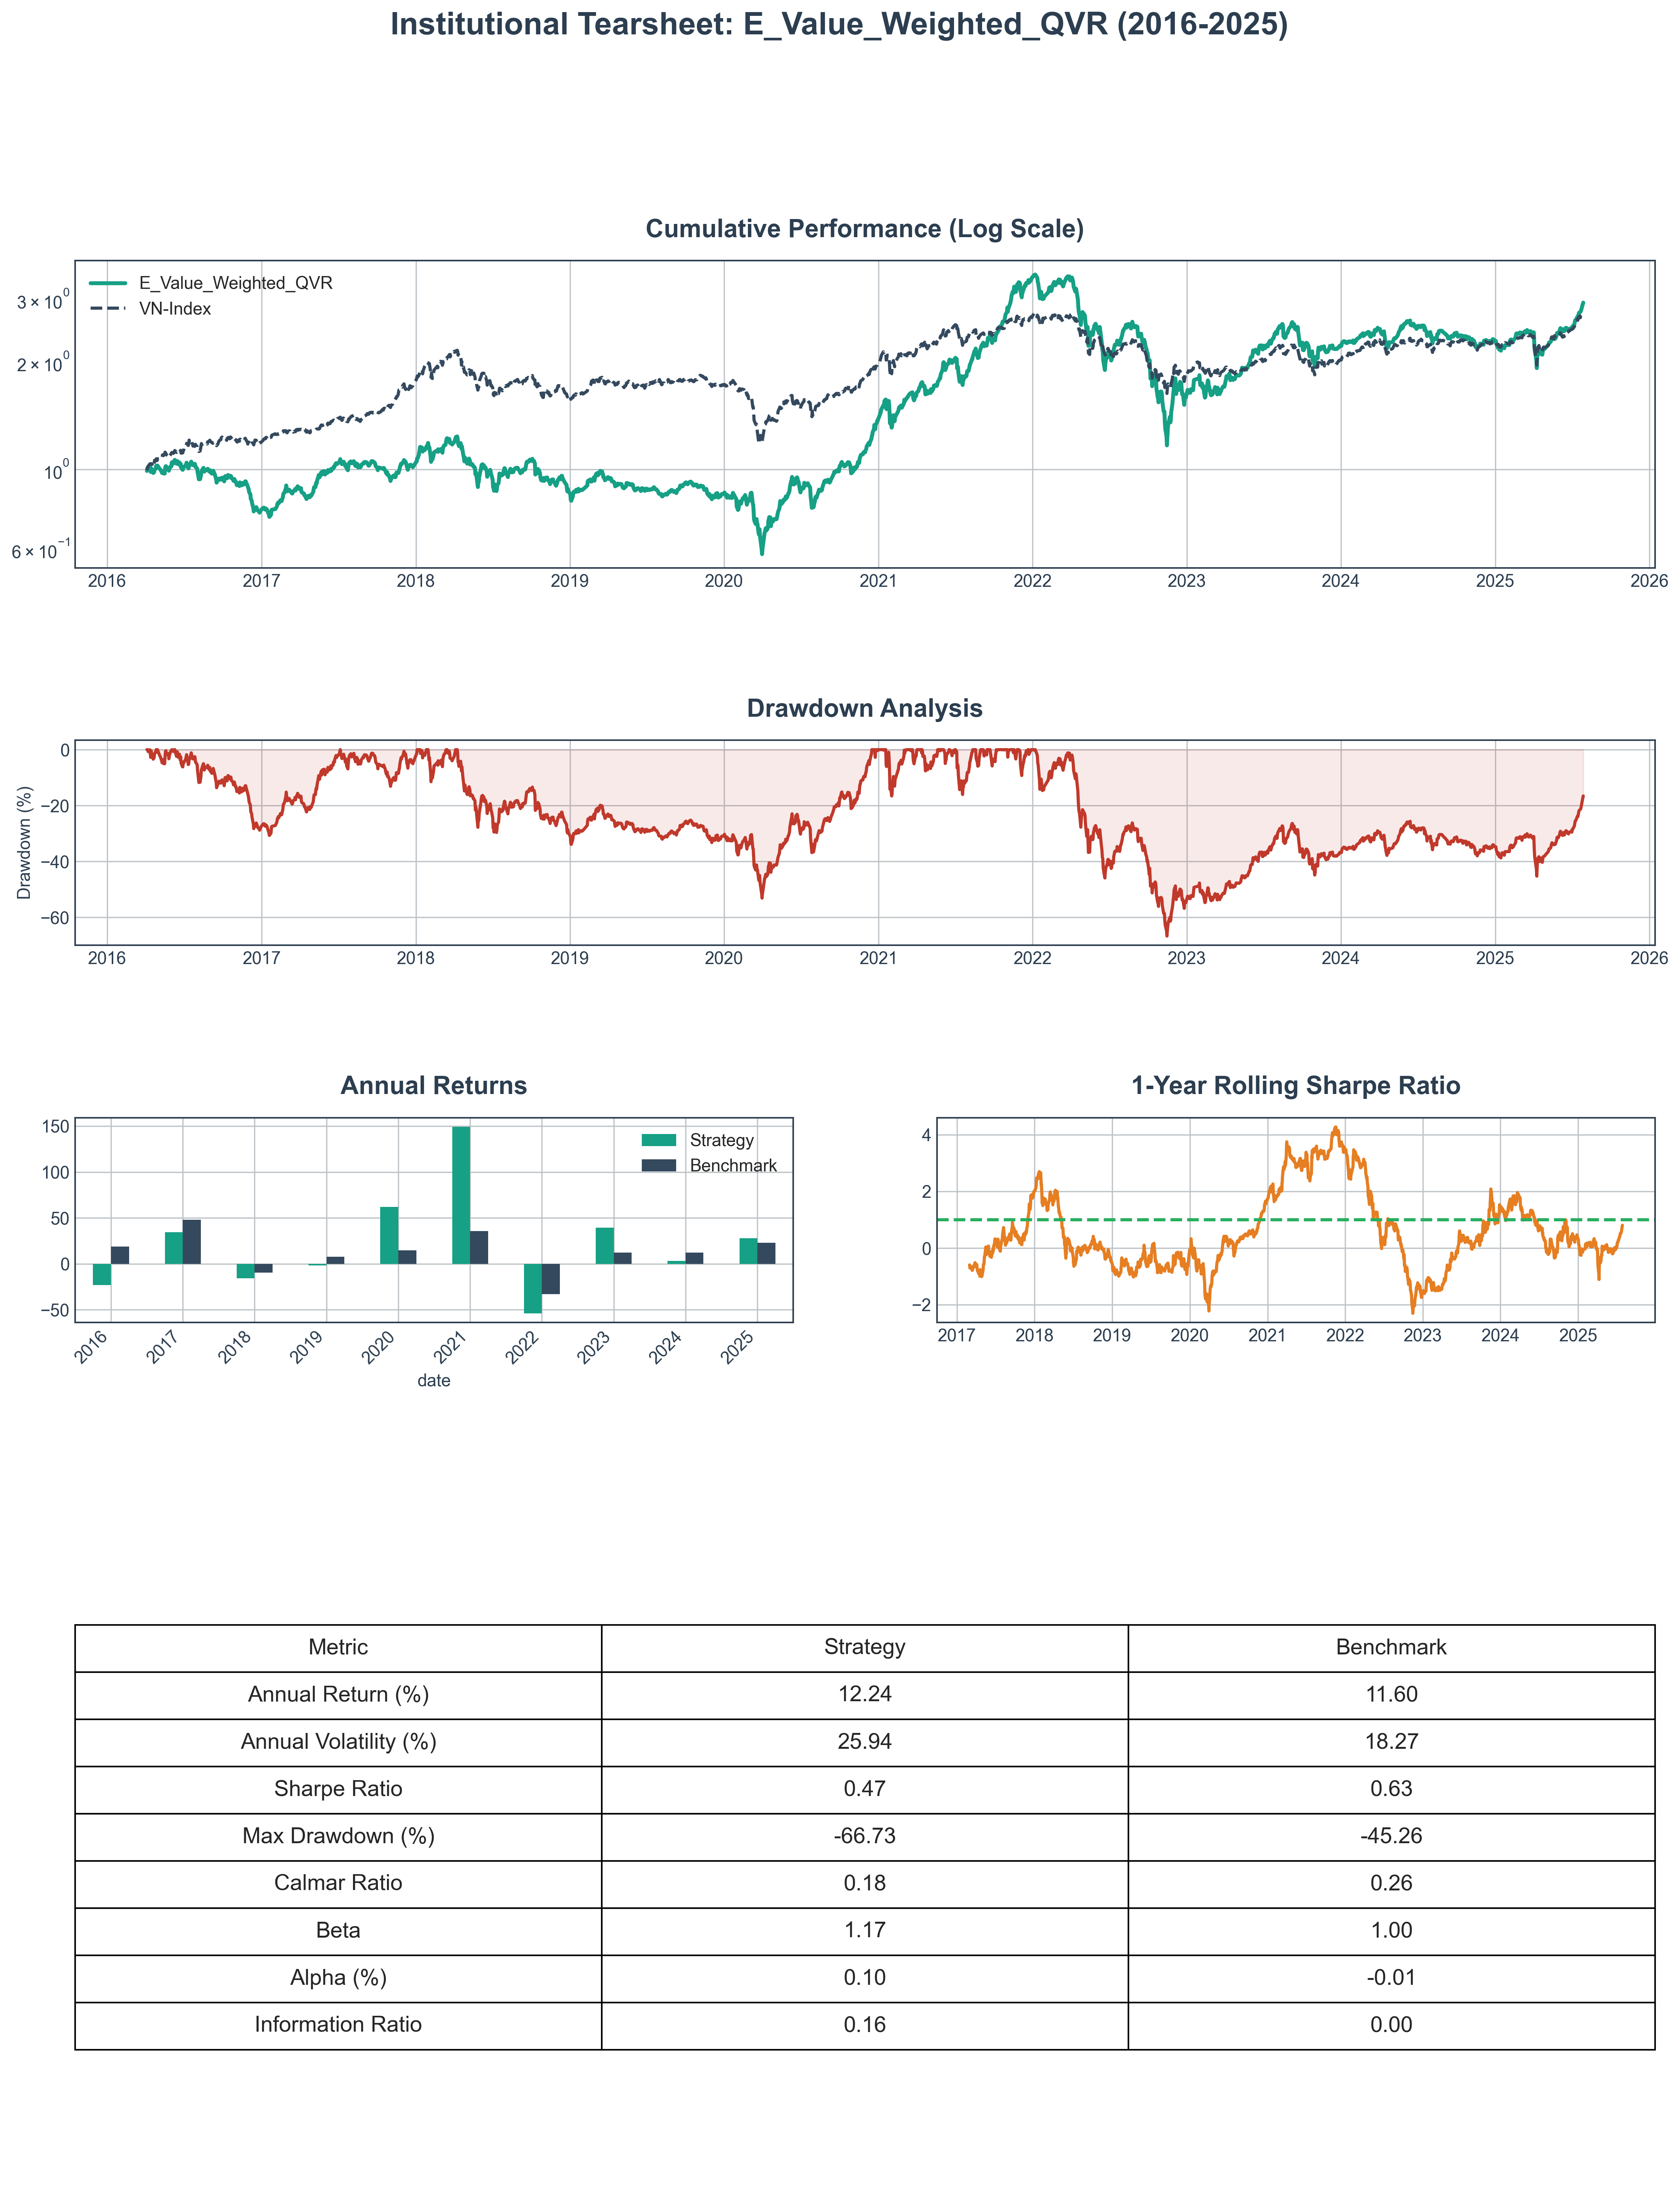


✅ Backtest for E_Value_Weighted_QVR complete.

✅ COMPLETED BACKTEST FOR: E_Value_Weighted_QVR

🎉 ALL BAKE-OFF BACKTESTS COMPLETED.


--- FINAL BAKE-OFF PERFORMANCE SUMMARY ---


Annual Return (%)  Sharpe Ratio  Max Drawdown (%)  \
Strategy                                                                  
A_Standalone_Value                13.52          0.52            -67.02   
B_Equal_Weighted_QVM              10.27          0.41            -68.77   
C_Equal_Weighted_QVR              10.91          0.44            -65.52   
D_Value_Weighted_QVM              11.15          0.43            -66.98   
E_Value_Weighted_QVR              12.24          0.47            -66.73   

                      Information Ratio  Alpha (%)  
Strategy                                            
A_Standalone_Value                 0.23       1.37  
B_Equal_Weighted_QVM               0.03      -1.76  
C_Equal_Weighted_QVR               0.06      -0.96  
D_Value_Weighted_QVM               0.09      -0.90  
E_Value_Weighted_QVR               0.16       0.10

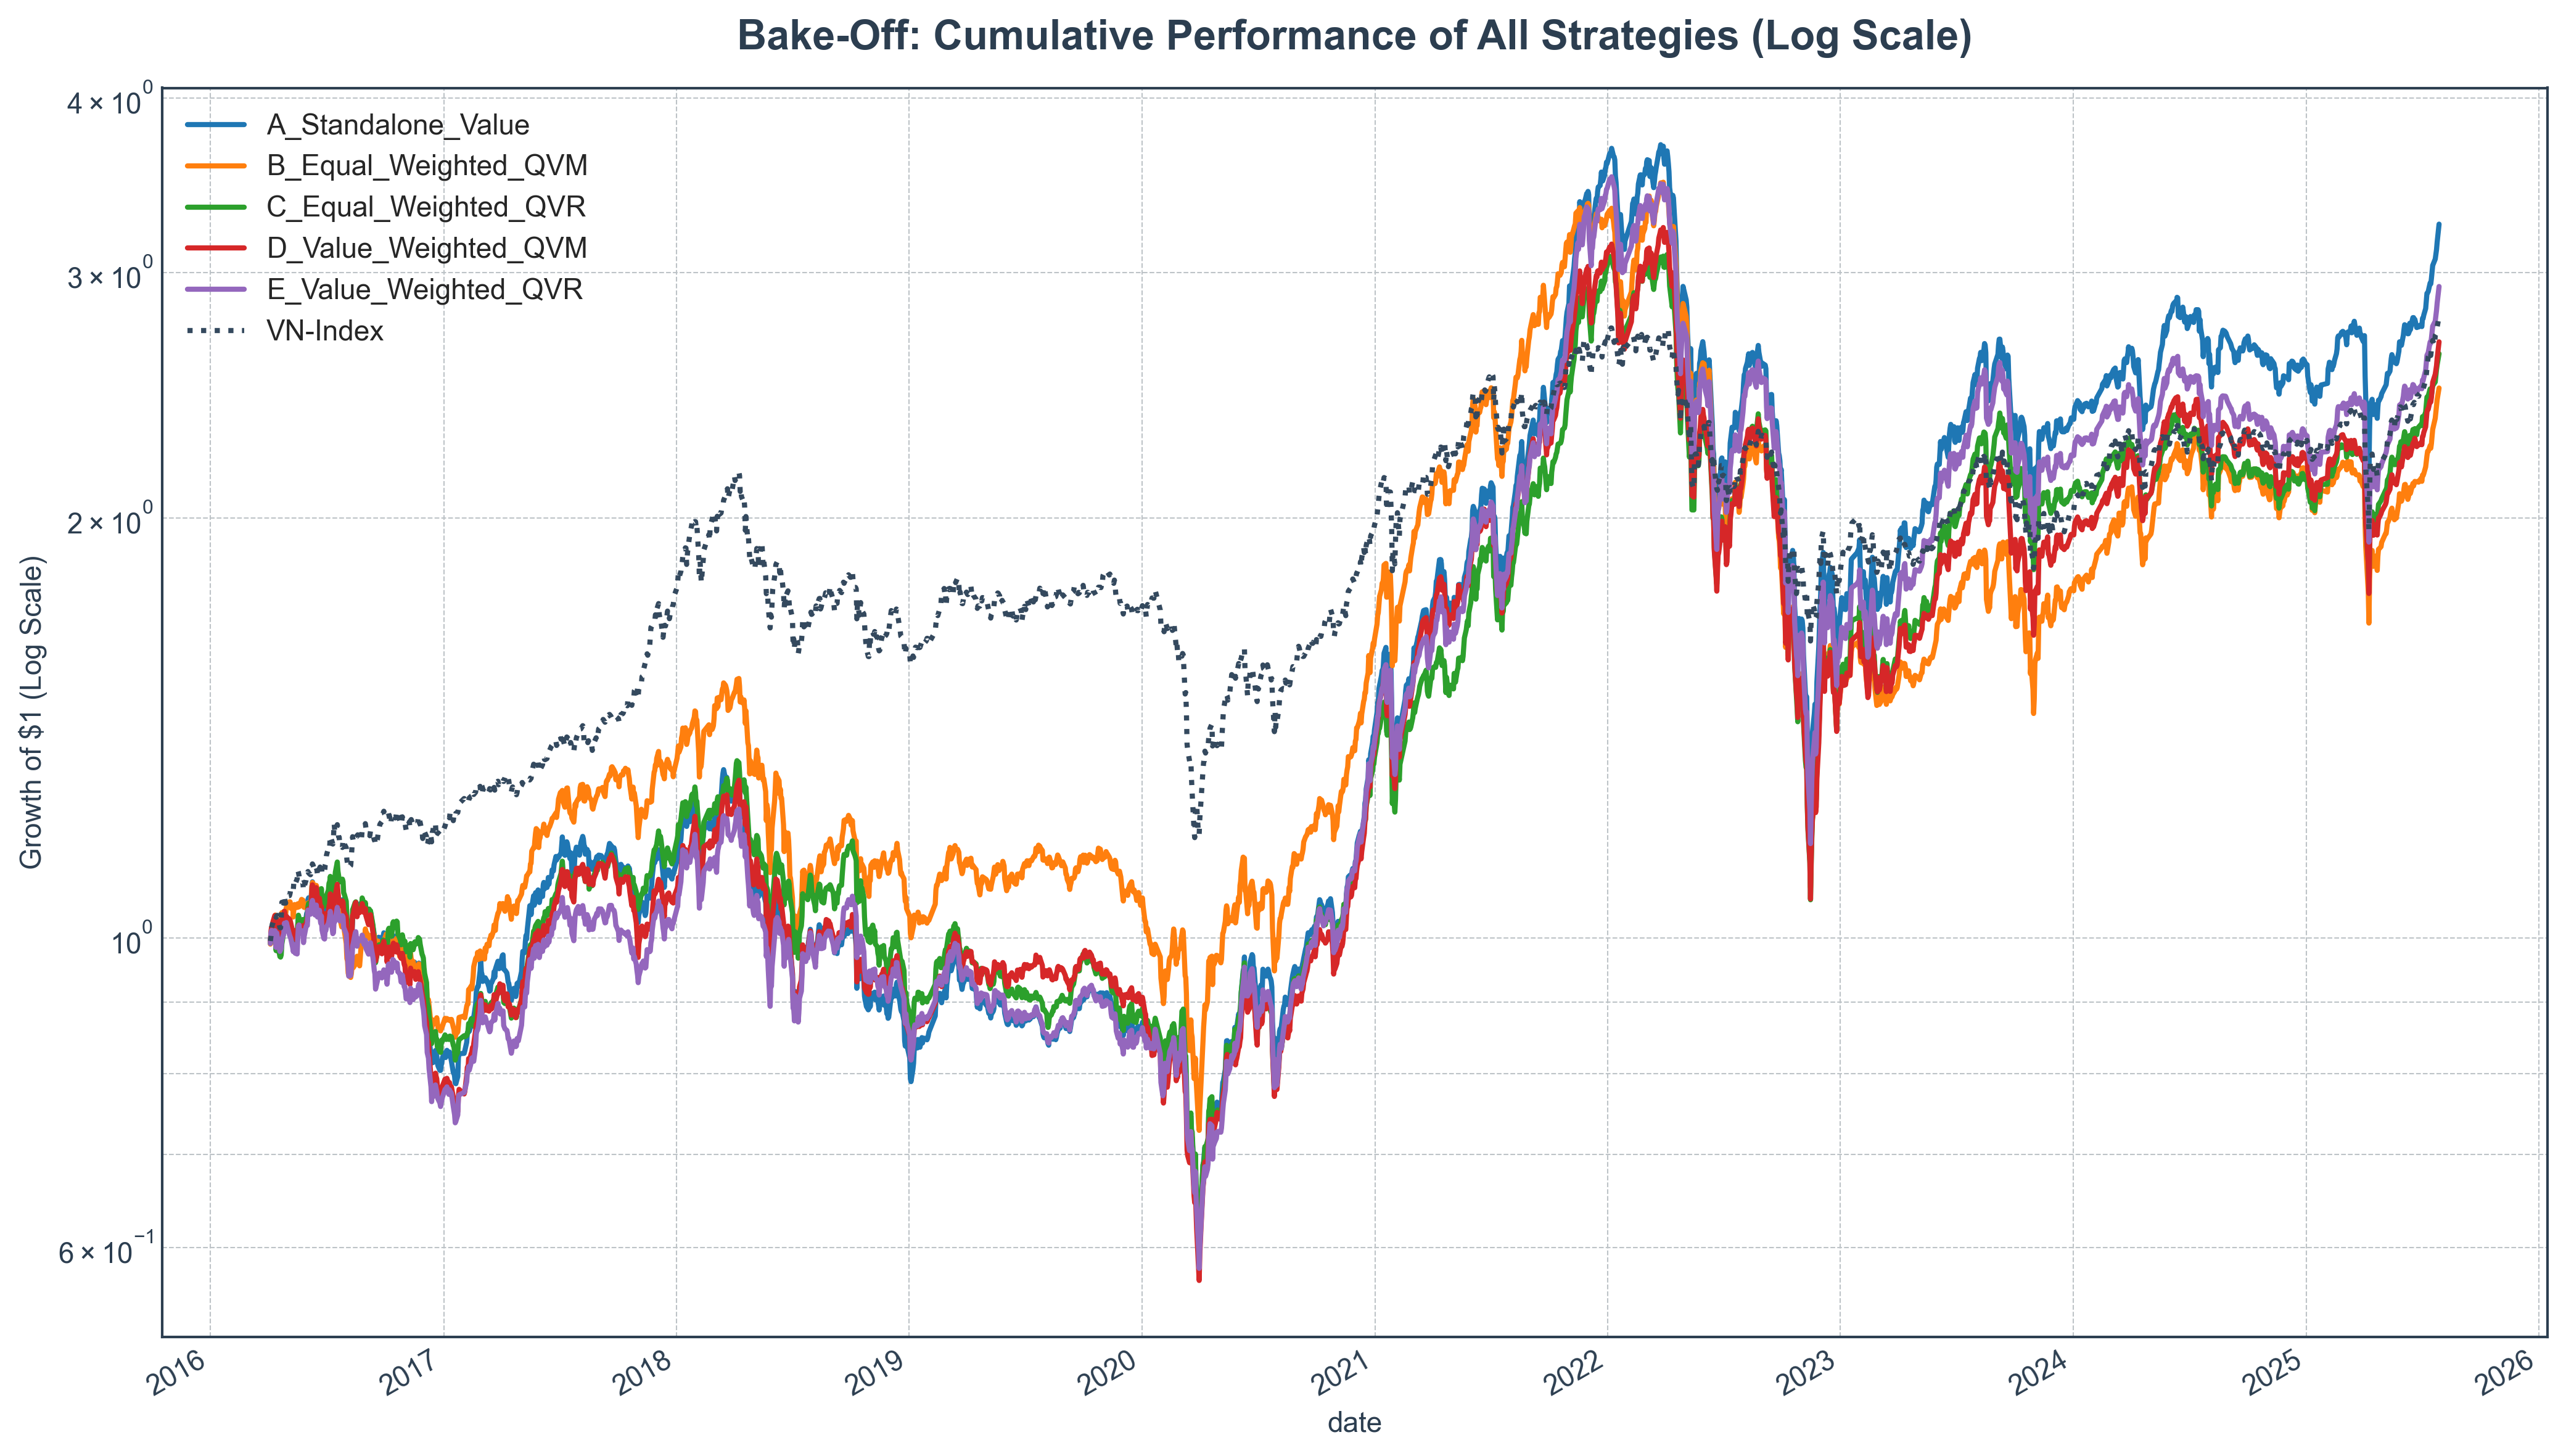

In [5]:
# ============================================================================
# PHASE 5: EXECUTE THE BAKE-OFF & ANALYZE RESULTS
# ============================================================================

# --- Store results for final comparison ---
bake_off_results = {}
all_returns_series = {}

# --- Loop through each configuration and run a full backtest ---
for config in ALL_CONFIGS:
    print("="*80)
    print(f"🚀 LAUNCHING BACKTEST FOR: {config['strategy_name']}")
    print("="*80)
    
    # 1. Instantiate the backtester with the specific config for this run
    backtester = UnifiedBacktester(
        config=config,
        factor_data=factor_data_raw,
        returns_matrix=daily_returns_matrix,
        benchmark_returns=benchmark_returns,
        db_engine=engine
    )
    
    # 2. Execute the run() method
    net_returns = backtester.run()
    
    # 3. Store the results
    all_returns_series[config['strategy_name']] = net_returns
    bake_off_results[config['strategy_name']] = backtester._calculate_performance_metrics(net_returns)
    
    print(f"\n✅ COMPLETED BACKTEST FOR: {config['strategy_name']}")

print("\n" + "="*80)
print("🎉 ALL BAKE-OFF BACKTESTS COMPLETED.")
print("="*80)

# --- Final Summary Comparison ---
summary_df = pd.DataFrame(bake_off_results).T
summary_df.index.name = "Strategy"

print("\n\n--- FINAL BAKE-OFF PERFORMANCE SUMMARY ---")
display(summary_df[['Annual Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Information Ratio', 'Alpha (%)']].round(2))

# --- Visualize the Equity Curves for a clear comparison ---
fig, ax = plt.subplots(figsize=(14, 8))

for name, returns in all_returns_series.items():
    first_trade = returns.loc[returns != 0].index.min()
    (1 + returns.loc[first_trade:]).cumprod().plot(ax=ax, label=name)

(1 + benchmark_returns.loc[first_trade:]).cumprod().plot(ax=ax, label='VN-Index', color=PALETTE['secondary'], linestyle=':')

ax.set_title('Bake-Off: Cumulative Performance of All Strategies (Log Scale)', fontweight='bold')
ax.set_ylabel('Growth of $1 (Log Scale)')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()